In [17]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as datetime

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

from mpl_toolkits.axes_grid1 import make_axes_locatable

import xflib
xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')



# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

# Volume of voxel:
def voxel_volume(points):
    tri = Delaunay(points.T)
    v = 0
    for row in tri.simplices:
        a = points[:,row[0]]
        b = points[:,row[1]]
        c = points[:,row[2]]
        d = points[:,row[3]]
        
        v += np.abs( np.dot(a - d, np.cross(b-d, c-d)))/6.
    return v

def rotate_latlon(raypos, itime, dlat, dlon, xf=None):
    if xf is None:
        xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')
        
    newpos = np.zeros_like(raypos)
    for ind in range(np.shape(raypos)[1]):
#         print ind
        tmp = xf.sm2rllmag(raypos[:,ind], itime)
        tmp[1] += dlat
        tmp[2] += dlon
        newpos[:,ind] = xf.rllmag2sm(tmp, itime)
    
    return newpos






In [ ]:
# 2d ray loader (rotate and clone to get longitudes):
# Full 3d-ray loader:
ray_dir = '/shared/users/asousa/WIPP/rays/2d/nightside/gcpm_kp0/'
from raytracer_utils import read_rayfile, read_damp
from scipy.spatial import Delaunay
from scipy import stats

flash_lat = 40
flash_lon = 76

itime = datetime.datetime(2010,1,1,0,0,0)
max_dist = 1500 #km
tmax = 10
dt   = 0.1
t = np.arange(0,tmax, dt)
        
R_E = 6371e3;
Hz2Rad = 2.*np.pi
D2R = np.pi/180.
H_IONO = 1e5


d = os.listdir(ray_dir)
freqs = sorted([int(f[2:]) for f in d if f.startswith('f_')])
d = os.listdir(os.path.join(ray_dir, 'f_%d'%freqs[0]))
lons = sorted([float(f[4:]) for f in d if f.startswith('lon_')])
d = os.listdir(os.path.join(ray_dir, 'f_%d'%freqs[0], 'lon_%d'%lons[0]))
lats = sorted([float(s.split('_')[2]) for s in d if s.startswith('ray_')])

# Closest available longitude to the flash:
center_lon = lons[np.argmin(np.abs(np.array(lons) - flash_lon))]
center_lat = lats[np.argmin(np.abs(np.array(lats) - flash_lat))]


# Latitude spacing:
# dl = stats.mode(np.diff(lats))[0][0]
dl = 1

newlons = np.array([flash_lon - dl/2., flash_lon + dl/2.])
latgrid, longrid = np.meshgrid(lats,newlons)
latln_pairs = zip(latgrid.ravel(), longrid.ravel())

pairs_in_range = []

# Select points within range.
# Prune out some points the further out we go:
for coords in latln_pairs:
    cur_d = haversine_np(flash_lon, flash_lat, coords[1], coords[0])
    if cur_d < max_dist:
        pairs_in_range.append(coords)
            
# print pairs_in_range
    
        
# Load and interpolate the center longitude entries:
center_data = dict()
for freq in freqs:
    print "freq: ", freq
    for lat in np.unique([x[0] for x in pairs_in_range]):
        lon = center_lon
        filename = os.path.join(ray_dir,'f_%d'%freq,'lon_%d'%lon,'ray_%d_%d_%d.ray'%(freq,lat,lon))
#         print filename
        rf = read_rayfile(filename)[0]
        
        filename = os.path.join(ray_dir,'f_%d'%freq,'lon_%d'%lon,'damp_%d_%d_%d.ray'%(freq,lat,lon))
        df = read_damp(filename)[0]
        
        t_cur = t[t <= rf['time'].iloc[-1]]
        
        # Interpolate onto our new time axis:
        x = interpolate.interp1d(rf['time'],rf['pos']['x']).__call__(t_cur)/R_E
        y = interpolate.interp1d(rf['time'],rf['pos']['y']).__call__(t_cur)/R_E
        z = interpolate.interp1d(rf['time'],rf['pos']['z']).__call__(t_cur)/R_E
        d = interpolate.interp1d(df['time'],df['damping']).__call__(t_cur)
        
        # Stash it somewhere:
        key = (freq, lat, lon)
        curdata = dict()
        curdata['pos'] = np.vstack([x,y,z])
        curdata['damp']= d
        curdata['nt'] = len(t_cur)
        center_data[key] = curdata
#         dlon = lon - center_lon
#         newpos = rotate_latlon(curdata['pos'],itime)
        

In [20]:
# Rotate data from center to target longitudes:
itime = datetime.datetime(2010,1,1,0,0,0)
ray_data = dict()
for key in center_data.keys():
    for lon in newlons:
        newkey = (key[0], key[1], lon)
        dlon = lon - key[2] 
        d = dict()
        d['pos'] = rotate_latlon(center_data[key]['pos'],itime, 0, dlon, xf)
        d['damp']=center_data[key]['damp']
        ray_data[newkey] = d
        


(200, 47.0, 75.5)
(200, 47.0, 76.5)
(16040, 29.0, 75.5)
(16040, 29.0, 76.5)
(3350, 42.0, 75.5)
(3350, 42.0, 76.5)
(200, 30.0, 75.5)
(200, 30.0, 76.5)
(2860, 46.0, 75.5)
(2860, 46.0, 76.5)
(8570, 42.0, 75.5)
(8570, 42.0, 76.5)
(5360, 42.0, 75.5)
(5360, 42.0, 76.5)
(8570, 41.0, 75.5)
(8570, 41.0, 76.5)
(440, 29.0, 75.5)
(440, 29.0, 76.5)
(1120, 52.0, 75.5)
(1120, 52.0, 76.5)
(11720, 50.0, 75.5)
(11720, 50.0, 76.5)
(16040, 41.0, 75.5)
(16040, 41.0, 76.5)
(2090, 38.0, 75.5)
(2090, 38.0, 76.5)
(230, 49.0, 75.5)
(230, 49.0, 76.5)
(16040, 50.0, 75.5)
(16040, 50.0, 76.5)
(3350, 50.0, 75.5)
(3350, 50.0, 76.5)
(2090, 42.0, 75.5)
(2090, 42.0, 76.5)
(11720, 33.0, 75.5)
(11720, 33.0, 76.5)
(11720, 49.0, 75.5)
(11720, 49.0, 76.5)
(600, 32.0, 75.5)
(600, 32.0, 76.5)
(5360, 28.0, 75.5)
(5360, 28.0, 76.5)
(1790, 33.0, 75.5)
(1790, 33.0, 76.5)
(200, 34.0, 75.5)
(200, 34.0, 76.5)
(320, 42.0, 75.5)
(320, 42.0, 76.5)
(510, 29.0, 75.5)
(510, 29.0, 76.5)
(2860, 48.0, 75.5)
(2860, 48.0, 76.5)
(10030, 50.0, 75

In [110]:
from graf_iono_absorp import total_input_power, MLT, input_power_scaling
from scipy.integrate import nquad

R_E = 6371e3;
Hz2Rad = 2.*np.pi
D2R = np.pi/180.
H_IONO = 1e5

I0 = -10000
raylats =np.unique(np.array(pairs_in_range)[:,0])
raylons =np.unique(np.array(pairs_in_range)[:,1])

print raylats, raylons

inp_pwrs = dict()

freq_pairs = zip(freqs[0:-1], freqs[1:])
lat_pairs  = zip(raylats[0:-1],raylats[1:])
lon_pairs  = zip(raylons[0:-1],raylons[1:])
print lon_pairs

flash_pos_mag = [1, flash_lat, flash_lon]
flash_pos_sm = xf.rllmag2sm(flash_pos_mag, itime)


opts = dict()
opts['epsabs']= 1.5e-8
opts['epsrel']= 1.5e-8
opts['limit']= 10

def integrand(inw, inlat, inlon):
    mlt = MLT(itime, inlon, xf);
    tmp_coords = [1, inlat, inlon];
    x_sm = xf.rllmag2sm(tmp_coords, itime);

    pwr = input_power_scaling(flash_pos_sm, x_sm, inlat, inw, I0, mlt, xf);
    return pwr*(R_E + H_IONO)*D2R*(R_E + H_IONO)*np.cos(D2R*lat)*D2R

pwr_vec = np.zeros(len(lat_pairs)) 
for f1, f2 in freq_pairs[1:2]:
# for f1, f2 in [(200, 30000)]:
    for ind, (lat1, lat2) in enumerate(lat_pairs):
        print lat1, lat2
        clat = (lat1 + lat2)/2.
        w1 = Hz2Rad*f1
        w2 = Hz2Rad*f2
        w   = Hz2Rad*(f1 + f2)/2.
        dw  = np.abs(f1 - f2)*Hz2Rad
        
#         print integrand(w, lat, center_lon)
        ranges = [[w1, w2],[lat1, lat2], lon_pairs[0]]
        integ = nquad(integrand, ranges, opts=opts, full_output=False)
        print integ
        pwr = integ[0]
        pwr_vec[ind] = pwr
    
        
# ranges = [[200*Hz2Rad,30000*Hz2Rad],[0, 90], [50,105]]
# integ = nquad(integrand,ranges, opts=opts, full_output=True)

# print integ
# pwr = integ[0]
# print pwr

    

[ 27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.] [ 75.5  76.5]
[(75.5, 76.5)]
27.0 28.0
(0.0014613801933366342, 1.8288348221210538e-17)
28.0 29.0
(0.0018789591438594078, 2.374918521109005e-17)
29.0 30.0
(0.002469583649743984, 3.158499644583929e-17)
30.0 31.0
(0.003332453301460406, 4.3230581447266436e-17)
31.0 32.0
(0.004643170894932241, 6.129106871334921e-17)
32.0 33.0
(0.006731654117103822, 9.081322239658278e-17)
33.0 34.0
(0.01026476297262272, 1.423896808642009e-16)
34.0 35.0
(0.016719769887232828, 2.406197742868035e-16)
35.0 36.0
(0.029776111250871033, 4.505638813061663e-16)
36.0 37.0
(0.06009429223775319, 9.755456096651834e-16)
37.0 38.0
(0.14470480269240762, 2.579228581858783e-15)
38.0 39.0
(0.41548373018558626, 7.446993382356884e-15)
39.0 40.0
(0.5648674271493871, 3.43380688088961e-13)
40.0 41.0
(0.5655083825175721, 3.4453282943393523e-13)
41.0 42.0
(0.4173259548898436, 7.466542900934527e-15)

<IPython.core.display.Javascript object>


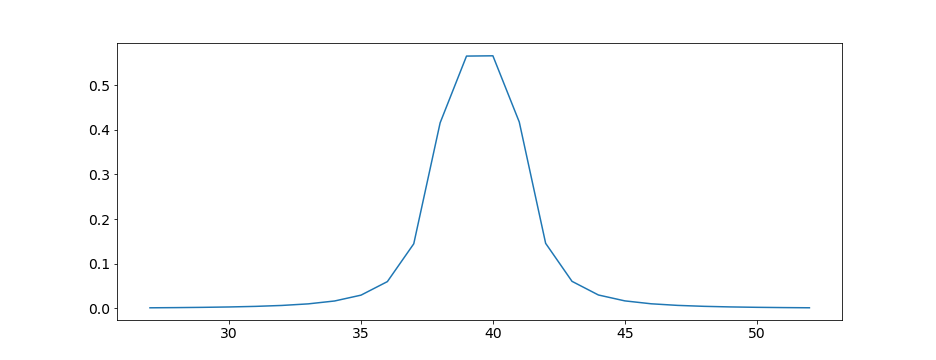

In [109]:
# Alright, there, we have a set of guide rays. The fuck do we do with it now?


fig, ax = plt.subplots(1,1)
ax.plot(raylats[0:-1], pwr_vec)

freq_pairs = zip(freqs[0:-1], freqs[1:])

#     vol = np.zeros_like(t)
    
    

In [83]:
import scipy.integrate
scipy.integrate.quad_explain()


    Compute a definite integral.

    Integrate func from `a` to `b` (possibly infinite interval) using a
    technique from the Fortran library QUADPACK.

    Parameters
    ----------
    func : function
        A Python function or method to integrate.  If `func` takes many
        arguments, it is integrated along the axis corresponding to the
        first argument.
        If the user desires improved integration performance, then f may
        instead be a ``ctypes`` function of the form:

            f(int n, double args[n]),

        where ``args`` is an array of function arguments and ``n`` is the
        length of ``args``. ``f.argtypes`` should be set to
        ``(c_int, c_double)``, and ``f.restype`` should be ``(c_double,)``.
    a : float
        Lower limit of integration (use -numpy.inf for -infinity).
    b : float
        Upper limit of integration (use numpy.inf for +infinity).
    args : tuple, optional
        Extra arguments to pass to `func`.
    full_output :